# Hop Teaming Analysis - Database Preparation

## Team: The Hindenburgs

Tomo Umer

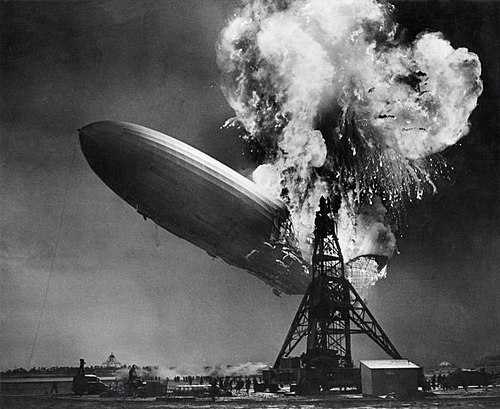

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import sqlite3

## Hop Teaming Dataset

Provided to us by our instructor Michael [here](https://drive.google.com/file/d/1t2-qcCSmXCFBJ-xvbRvMc2Nlu9VTsZts/view?usp=sharing). More information about the Hop Teaming data can be found at https://careset.com/docgraph-hop-teaming-dataset/. 

Hop Teaming dataset has columns - from_npi, to_npi, patient_count, transaction_count, average_day_wait, std_day_wait, weill keep all.

I used the below code when testing it individually.

```
 chunks = pd.read_csv('../data/DocGraph_Hop_Teaming_2018.csv', chunksize = 10000)
 test_chunk = next(chunks)
 test_chunk.loc[(test_chunk['transaction_count'] >= 50) & (test_chunk['average_day_wait'] < 50)]
```

> NOTE: when going through the entire dataset to store it in the sqlite database, it takes a good 5 min and 20 sec to do so!

In [2]:
db = sqlite3.connect('../data/hop_teaming_database.sqlite')

for chunk in tqdm(pd.read_csv('../data/DocGraph_Hop_Teaming_2018.csv', chunksize = 10000)):
    # filter the required conditions (trying to eliminate accidental referrals)
    chunk.loc[(chunk['transaction_count'] >= 50) & (chunk['average_day_wait'] < 50)] 
    # Append the chunk to a calls table
    chunk.to_sql('hop_teaming', db, if_exists = 'append', index = False)

0it [00:00, ?it/s]

In [3]:
db.execute('CREATE INDEX from_to_npi ON hop_teaming(from_npi, to_npi)')

In [4]:
db.close()

The hop teaming dataset is pretty straightforward, only 6 columns. Need to apply some filters which I'll get to later.

## NNPES dataset

To supplement the Hop Teaming, download the NPPES Data Dissemination from [here](https://download.cms.gov/nppes/NPI_Files.html)

In [ ]:
# below code allows to see all columns, this dataset has 330;
# if you want to display less, replace None with columns to display, e.g. 10
pd.set_option('display.max_columns', None)

Same as above, for testing

```
chunks = pd.read_csv('../data/npidata_pfile_20050523-20230212.csv', chunksize = 10000)
test_chunk = next(chunks)
```

As I was exploring the taxonomy, I found out that there are some providers that have for taxonomy switch 'X' on all taxonomies instead of Y or N.

` test_chunk.loc[(test_chunk['Healthcare Provider Primary Taxonomy Switch_1'] != 'Y') & (test_chunk['Healthcare Provider Primary Taxonomy Switch_1'] != 'N')] `

In order to access the taxonomies, I first found out how to loop over the columns:

```
for i in range(1,16):
    print(test_chunk.loc[test_chunk[f'Healthcare Provider Primary Taxonomy Switch_{i}'] == 'Y', f'Healthcare Provider Taxonomy Code_{i}'].count())
```

And then defined the lambda function to apply:

```
def find_taxonomy(col):  
    if col['Healthcare Provider Primary Taxonomy Switch_1'] == 'Y':
        return col['Healthcare Provider Taxonomy Code_1']
    elif col['Healthcare Provider Primary Taxonomy Switch_2'] == 'Y':
    ...
    similar code repeated for 15 times
    ...
    elif col['Healthcare Provider Primary Taxonomy Switch_15'] == 'Y':
        return col['Healthcare Provider Taxonomy Code_15']      
    return 'no primary taxonomy'
```

Below is the compacted version

> side note: I couldn't find any examples where switch 2 was Y, and the Taxonomy Codes 1 and 2 were actually different

In [6]:
def find_taxonomy(col):
    for i in range(1, 16):
        taxonomy_switch = f'Healthcare Provider Primary Taxonomy Switch_{i}'
        taxonomy_value = f'Healthcare Provider Taxonomy Code_{i}'
        if col.get(taxonomy_switch) == 'Y':
            return col.get(taxonomy_value)
    return 'no primary taxonomy'

In [8]:
%%capture [--no-stderr]
# the capture above is here so that it doesn't show warnings about columns types and so that I avoid manually setting dozens of columns dtypes!

db = sqlite3.connect('../data/hop_teaming_database.sqlite')

for chunk in tqdm(pd.read_csv('../data/npidata_pfile_20050523-20230212.csv', chunksize = 10000, dtype={'Provider Business Practice Location Address Postal Code': object})):

    # first extract the primary taxonomy
    chunk['Primary Taxonomy'] = chunk.apply(lambda col: find_taxonomy(col), axis=1)

    # take only the first 5 ZIP digits
    chunk['Provider Business Practice Location Address Postal Code'] = chunk['Provider Business Practice Location Address Postal Code'].str[:5]

    # next, only keep columns we're interested in and renaming so that there are no ()
    chunk = (
        chunk 
        [['NPI',
        'Entity Type Code',
        'Provider Organization Name (Legal Business Name)',
        'Provider Last Name (Legal Name)',
        'Provider First Name',
        'Provider Middle Name',
        'Provider Name Prefix Text',
        'Provider Name Suffix Text',
        'Provider Credential Text',
        'Provider First Line Business Practice Location Address',
        'Provider Second Line Business Practice Location Address',
        'Provider Business Practice Location Address City Name',
        'Provider Business Practice Location Address State Name',
        'Provider Business Practice Location Address Postal Code',
        'Primary Taxonomy']]
        .rename(columns={'Provider Organization Name (Legal Business Name)': 'Provider Organization Name',
        'Provider Last Name (Legal Name)': 'Provider Last Name'})
    )

    # Then clean up the column names
    chunk.columns = [x.lower().replace(' ', '_') for x in chunk.columns]

    # Finally, the chunk to a calls table
    chunk.to_sql('npidata_pfile', db, if_exists = 'append', index = False)            

In [9]:
db.execute('CREATE INDEX npi ON npidata_pfile(npi)')

In [10]:
db.close()

## National Uniform Claim Committee

Classification for taxonomy codes

In [16]:
# nucc_taxonomy = pd.read_csv('../data/nucc_taxonomy_230.csv', encoding = 'unicode_escape')
# nucc_taxonomy

In [100]:
# 873 rows, 8 columns -- nucc_taxonomy.shape
# 238 have 'Definition to come' ... when though?
# nucc_taxonomy.loc[nucc_taxonomy['Definition'] == 'Definition to come...']

In [11]:
db = sqlite3.connect('../data/hop_teaming_database.sqlite')

nucc_taxonomy = pd.read_csv('../data/nucc_taxonomy_230.csv', encoding = 'unicode_escape')

# lowercase column names and replace spaces
nucc_taxonomy.columns = [x.lower().replace(' ', '_') for x in nucc_taxonomy.columns]

# add table to database
nucc_taxonomy.to_sql('nucc_taxonomy', db, if_exists = 'append', index = False)

#create index
db.execute('CREATE INDEX code ON nucc_taxonomy(code)')

db.close()

## ZIP code to CBSA

In [28]:
# zip_cbsa = pd.read_excel('../data/ZIP_CBSA_122021.xlsx')
# zip_cbsa

In [12]:
db = sqlite3.connect('../data/hop_teaming_database.sqlite')

zip_cbsa = pd.read_excel('../data/ZIP_CBSA_122021.xlsx', index_col = None, header = 0, dtype={'zip': object})

# add table to database
zip_cbsa.to_sql('zip_cbsa', db, if_exists = 'append', index = False)

#create index
db.execute('CREATE INDEX zip ON zip_cbsa(zip)')

db.close()